In [31]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    look_at_rotation
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import pytorch3d.renderer
print(pytorch3d.renderer.__file__)
%load_ext autoreload
%autoreload 2

d:\1_projects\200323_pytorch3dstart\pytorch3d\renderer\__init__.py
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# !mkdir -p data/cow_mesh
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
# !wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

# Load mesh & create texturemap

In [79]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
obj_filename = '3_input/cow_mesh'
print(os.path.exists(obj_filename))
print(obj_filename)
# Load obj file
mesh_ref = load_objs_as_meshes([obj_filename + '/cow.obj'], device=device)
mesh_learned = load_objs_as_meshes([obj_filename + '/learned_cow.obj'], device=device)
texture_image0 = mesh_ref.textures.maps_padded()
print(texture_image0.shape)
print(np.max(texture_image0.cpu().numpy()))
print(type(texture_image0).__module__)
texture_image = torch.from_numpy(np.ones((1, 1024, 1024, 3)).astype(np.float32)).to(device)
print(texture_image.shape)

True
3_input/cow_mesh
Properties(normals=None, verts_uvs=tensor([[0.8004, 0.6675],
        [0.7896, 0.6682],
        [0.7999, 0.6639],
        ...,
        [0.5429, 0.3197],
        [0.4766, 0.3259],
        [0.4950, 0.2872]]), material_colors={'material_1': {'ambient_color': tensor([1., 1., 1.]), 'diffuse_color': tensor([1., 1., 1.]), 'specular_color': tensor([0., 0., 0.]), 'shininess': tensor([10.])}}, texture_images={'material_1': tensor([[[1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020],
         ...,
         [1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020]],

        [[1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020],
         ...,
         [1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020]],

        [[1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020],
         [1.0000, 0.9333, 0.9020],
     

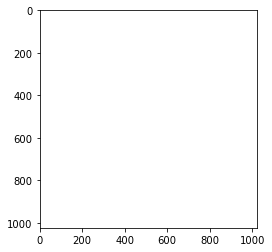

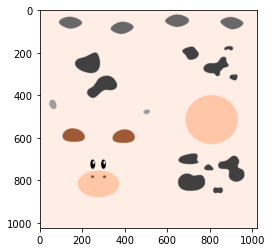

In [57]:
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.show()
plt.imshow(texture_image0.squeeze().cpu().numpy())
plt.show()

In [58]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size = None,  # this setting controls whether naive or coarse-to-fine rasterization is used
    max_faces_per_bin = None  # this setting is for coarse rasterization
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

torch.Size([1, 1024, 1024, 3])
torch.Size([1, 1024, 1024, 3])
1.0
1.0
1.0
1.1478012e-10


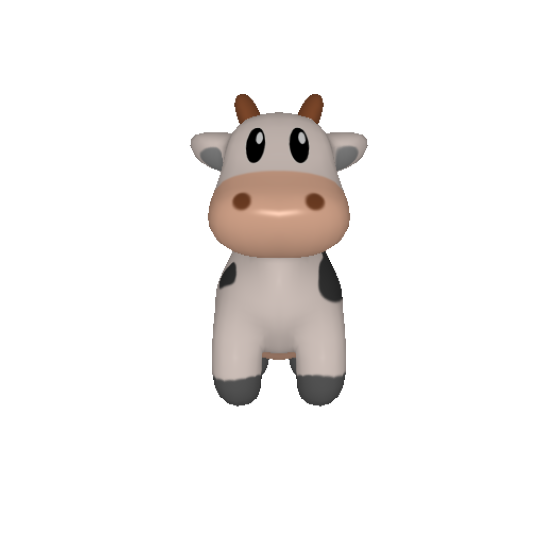

In [59]:
print(texture_image.shape)
print(texture_image0.shape)
images = renderer(mesh_ref, texturemaps=texture_image0)
print(np.max(texture_image0.cpu().numpy()))
print(np.max(texture_image.cpu().numpy()))
images_np = images[0, ..., :3].cpu().numpy()
print(np.max(images_np))
print(np.min(images_np))
plt.figure(figsize=(10, 10))
plt.imshow(images_np)
plt.grid("off");
plt.axis("off");

In [60]:
# Now move the light so it is on the +Z axis which will be behind the cow. 
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh_ref, lights=lights, texturemaps=texture_image)

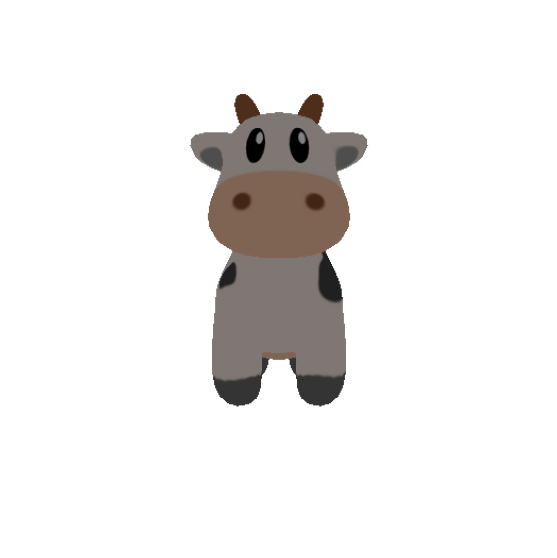

In [61]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [62]:
# Rotate the object by increasing the elevation and azimuth angles
R, T = look_at_view_transform(dist=2.7, elev=10, azim=-150)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the cow's face.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0
)

# Re render the mesh, passing in keyword arguments for the modified components.
print(cameras.R.shape)
print(cameras.T.shape)
print(cameras.R.is_cuda)
print(cameras.T.is_cuda)
images = renderer(mesh_ref, lights=lights, materials=materials, cameras=cameras, texturemaps=texture_image)

torch.Size([1, 3, 3])
torch.Size([1, 3])
True
True


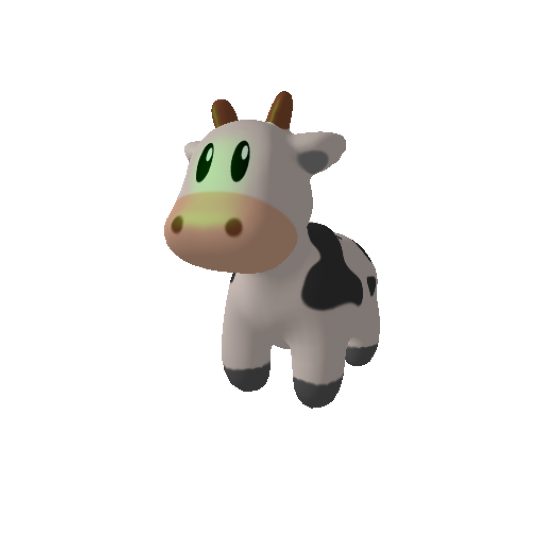

In [63]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

# Backpropagate on texture rendering

### ground-truth R and T

In [64]:
"""
torch.Size([1, 3, 3])
torch.Size([1, 3, 1])
"""
R, T = look_at_view_transform(dist=3, elev=0, azim=-90)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
image_ref = renderer(mesh_ref, cameras=cameras, texturemaps=texture_image0)
image_ref_np = image_ref[0, ..., :3].cpu().numpy()
cam_pos_gt = cameras.get_camera_center()
print(cam_pos_gt)

tensor([[-3.0000e+00,  0.0000e+00, -1.3113e-07]], device='cuda:0')


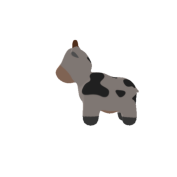

In [65]:
plt.figure(figsize=(3, 3))
plt.imshow(image_ref_np)
plt.grid("off");
plt.axis("off");

In [76]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, camera_pos, texture_maps):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        self.register_buffer('image_ref', image_ref)
        self.camera_position = torch.from_numpy(np.array(camera_pos).astype(np.float32)).to(meshes.device)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.texture_maps = nn.Parameter(
            texture_maps.clone().to(meshes.device))
        
    def forward(self):
        # Render the image using the updated camera position. Based on the new position of the 
        # camer we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T, texture_maps=self.texture_maps)
        
        # Calculate the silhouette loss
        loss = torch.sum((image - self.image_ref) ** 2)
        return loss, image

In [78]:
# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=mesh_learned, renderer=renderer, camera_pos=[0, 0, -3], texture_maps=texture_image).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model

loss, image0 = model()
image0_np = image0[0, ..., :3].detach().cpu().numpy()
print(image0_np.shape)
print('loss =',loss)
plt.figure(figsize=(3, 3))
plt.imshow(image0_np)
plt.grid("off");
plt.axis("off");

AttributeError: 'NoneType' object has no attribute 'faces_uvs_packed'

<ipython-input-236-72819d2d4c51>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  loop = tqdm_notebook(range(10000))


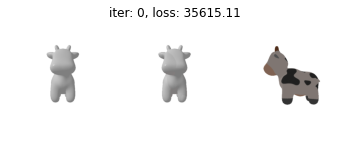

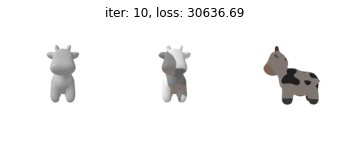

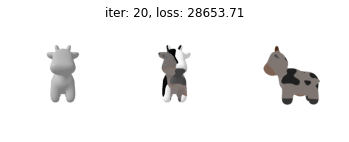

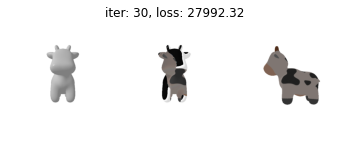

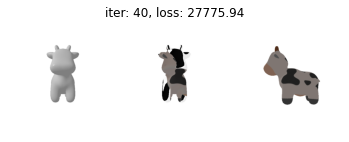

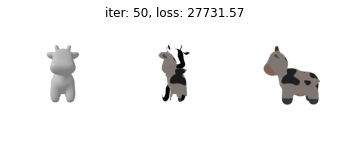

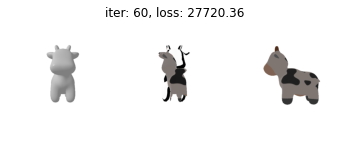

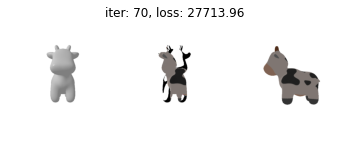

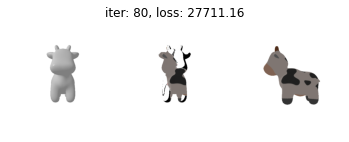

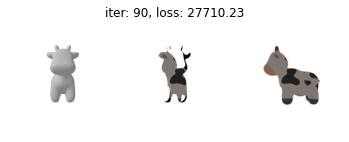

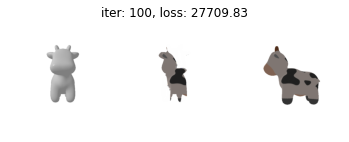

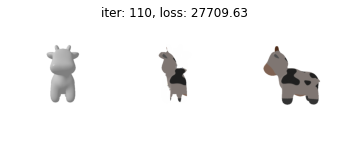

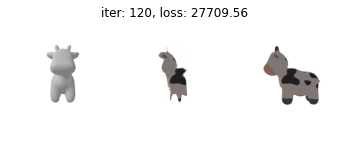

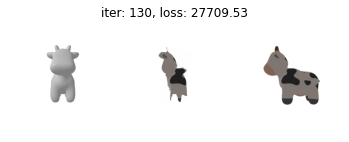

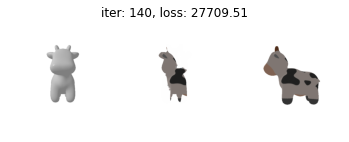

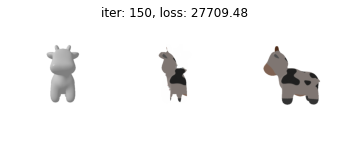

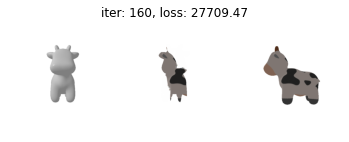

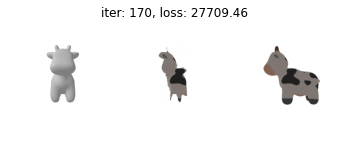

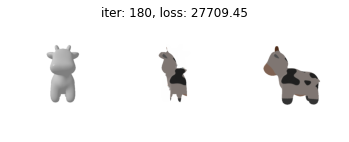

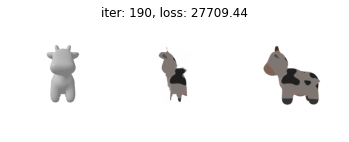

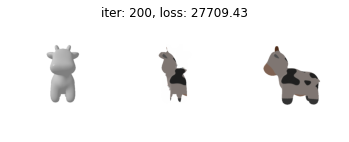

KeyboardInterrupt: 

In [236]:
filename_output = './4_output/out2.gif'
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

optimizer = torch.optim.Adam(model.parameters(), lr=0.025)

loop = tqdm_notebook(range(10000))

losses = []

cam_deg = 0

for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('[{}/{}] loss={:.6f}'.format(i, len(loop), loss.data))
    
    losses.append(loss)
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = renderer(meshes_world=model.meshes.clone(), R=R, T=T, texturemaps=model.texturemap)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        
        image_out = np.hstack([image0_np, image, image_ref_np])

        plt.figure()
        plt.imshow((255*image_out).astype(np.uint8))
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")
        plt.show()
        
        image_out = np.clip(image_out, 0, 1)
        image_out = img_as_ubyte(image_out)
        writer.append_data(image_out)
writer.close()

In [237]:
writer.close()

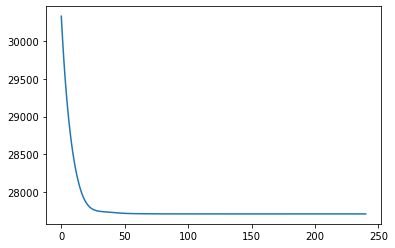

In [230]:

plt.plot(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


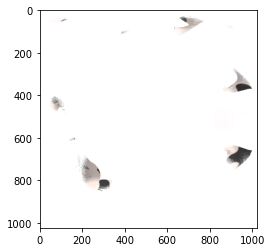

In [231]:
plt.imshow(model.texturemap.detach().cpu().numpy()[0, :, :, :])
plt.savefig('./texturemap_learned.png', dpi=300)